In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pickle
from tqdm import tqdm
import os
import sys

n_train = 12500
train_path = '/home/ubuntu/udacity_machine_learning/cats-vs-dogs/train/'
test_path = '/home/ubuntu/udacity_machine_learning/cats-vs-dogs/test/'
height = 128
width = 128

## 1. Data preprocessing
Since the sizes of images are random, I have to resize the images.
Most image sizes are 500 X 500. If I use cv2.imread to decompress JPG and read them into memory, the total volume will increase from 500 MB to 17 GB which is too large. It will also cost a long time to train the model. So I try to resize the images to 128 X 128.

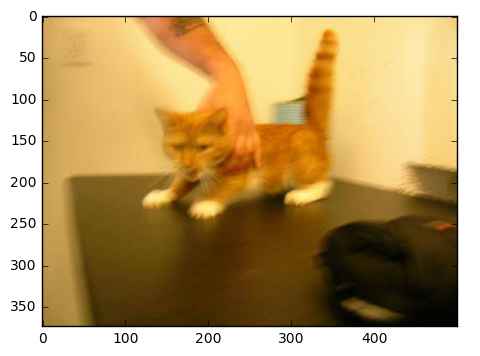

In [2]:
img = cv2.imread(train_path + "cat.0.jpg")

# show opencv graph with jupyter
show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img)
plt.show()


In [3]:
img_db = np.zeros((25000, height, width, 3), dtype=np.uint8)

# The first 12500 images are all cats
for i in tqdm(range(n_train)):
    img = cv2.imread(train_path + 'cat.' + str(i) + '.jpg')
    img = img[:, :, ::-1]
    img = cv2.resize(img, (height, width))   
    img_db[i] = img
# The rest 12500 images are all dogs    
for i in tqdm(range(n_train)):
    img = cv2.imread(train_path + 'dog.' + str(i) + '.jpg')
    img = img[:, :, ::-1]
    img = cv2.resize(img, (height, width))   
    img_db[i + n_train] = img
    

    


100%|██████████| 12500/12500 [01:11<00:00, 174.62it/s]


In [4]:
img_db.shape

(25000, 128, 128, 3)

In [5]:
# resized images 1.17G
str(sys.getsizeof(img_db)/1024/1024) + ' MB'

'1171.8751373291016 MB'

### Save the image data as pickle object for easy access

In [6]:
zeros = np.zeros(12500, dtype=np.uint8)    # cat = 0
ones = np.ones(12500, dtype=np.uint8)      # dog = 1
labels = np.concatenate((zeros, ones))
obj = {'img_db': img_db, 'img_labels': labels}
with open('train.p', 'wb') as file:
    pickle.dump(obj, file)                        

### Load preprocessed data

In [7]:
with open('train.p', 'rb') as f:
    train = pickle.load(f)

img_db = train['img_db']
img_labels = train['img_labels']
img_db.shape

(25000, 128, 128, 3)

### Randomly shuffle training data (keep the image related label unchanged)

In [8]:
img_index = np.arange(25000)
np.random.shuffle(img_index)
img_db_shuffled = np.zeros((25000, height, width, 3), dtype=np.uint8)
img_labels_shuffled = np.zeros(25000,dtype=np.uint8)
j = 0
for i in img_index:
    img_db_shuffled[j] = img_db[i]
    img_labels_shuffled[j] = img_labels[i]
    j += 1

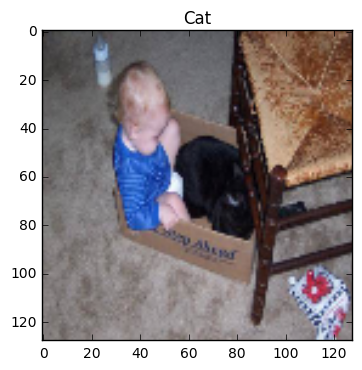

In [9]:
# check if the label and image match
img_id = np.random.choice(range(25000))
plt.imshow(img_db_shuffled[img_id])

if img_labels_shuffled[img_id] == 1:
    label = 'Dog'
else:
    label = 'Cat'
    
plt.title(label)
plt.show()

### Split into training and validation sets

In [10]:
x_val, y_val = img_db_shuffled[:2500], img_labels_shuffled[:2500]
x_train, y_train = img_db_shuffled[2500:], img_labels_shuffled[2500:]
print(x_val.shape)
print(x_train.shape)

(2500, 128, 128, 3)
(22500, 128, 128, 3)


## 2. Train the model

In [11]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.layers.normalization import BatchNormalization

# CCM -> CCM -> CCM -> CCM -> Flatten -> Dropout -> FC -> output
def create_model(num_CCM, num_kernel):
    
    # Input layer
    input_tensor = Input((height, width, 3))
    x = input_tensor
    
    
    # Convolution + Pooling Layer (4层CCM级联，模拟VGG16的结构)
    # 32C 32C M -> 64C 64C M -> 128C 128C M -> 256C 256C M
    for i in range(num_CCM):
        conv_num_output = num_kernel * (2**i)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPool2D(pool_size=2, strides=2, padding='valid')(x)
        
    # Flatten
    x = Flatten()(x)
    
    
    # Dropout
    x = Dropout(0.25)(x)
    
    # Fully connected layer
    x = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)
    
    model = Model(inputs=input_tensor, outputs=x, name='dogVScat')
    return model

Using TensorFlow backend.


In [12]:
# Create model: 3 CCM 
model = create_model(3, 32)

# 2. Compile Model with metrics/optimizer/loss
model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [13]:
# check model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        18496     
__________

## Train the model through training set and verify it through validation set

In [14]:
model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=32, epochs=10)

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 151s - loss: 0.7613 - acc: 0.6645 - val_loss: 0.6976 - val_acc: 0.7192
Epoch 2/10
22500/22500 [==============================] - 131s - loss: 0.5409 - acc: 0.7693 - val_loss: 0.7392 - val_acc: 0.6980
Epoch 3/10
22500/22500 [==============================] - 131s - loss: 0.4347 - acc: 0.8201 - val_loss: 0.6309 - val_acc: 0.7836
Epoch 4/10
22500/22500 [==============================] - 131s - loss: 0.3503 - acc: 0.8580 - val_loss: 0.3765 - val_acc: 0.8548
Epoch 5/10
22500/22500 [==============================] - 131s - loss: 0.2850 - acc: 0.8897 - val_loss: 0.7642 - val_acc: 0.7684
Epoch 6/10
22500/22500 [==============================] - 131s - loss: 0.2234 - acc: 0.9113 - val_loss: 0.7419 - val_acc: 0.8088
Epoch 7/10
22500/22500 [==============================] - 131s - loss: 0.1907 - acc: 0.9239 - val_loss: 0.4898 - val_acc: 0.8436
Epoch 8/10
22500/22500 [========================

In [17]:
# Save model
#from keras.models import load_model
#model.save('cnn.h5')

#Load model
from keras.models import load_model
model = load_model('cnn.h5')

In [11]:
# Test images
img_test = np.zeros((12500, height, width, 3), dtype=np.uint8)


for i in tqdm(range(n_train)):
    img = cv2.imread(test_path + str(i+1) + '.jpg')
    img = img[:, :, ::-1]
    img = cv2.resize(img, (height, width))   
    img_test[i ] = img

100%|██████████| 12500/12500 [00:42<00:00, 293.90it/s]


In [12]:
img_test.shape

(12500, 128, 128, 3)

In [13]:
obj = {'img_test': img_test}
with open('test.p', 'wb') as file:
    pickle.dump(obj, file)                        

In [13]:
with open('test.p', 'rb') as f:
    test = pickle.load(f)

img_test = test['img_test']
img_test.shape

(12500, 128, 128, 3)

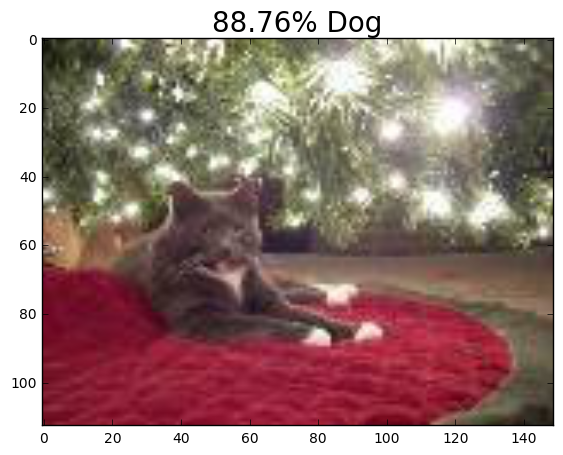

In [14]:
random_img = np.random.choice(range(12500))
img = cv2.imread(test_path + str(random_img) + '.jpg')
img = img[:, :, ::-1]
img_resize = cv2.resize(img, (128, 128))
x = img_resize[None, :]
y_pred = model.predict(x)
y_pred = y_pred[0][0]
result = ''
prob = ''
if (y_pred >= 0.5):
    result = 'Dog'
    prob = np.round(y_pred * 100, 2)
else:
    result = 'Cat'
    prob = 100 - np.round(y_pred * 100, 2)
    
plt.figure(figsize=(15, 5))
plt.imshow(img, cmap='gray')
plt.title(str(prob) + '% ' + result, size=20)
plt.show()

In [15]:
output = ['id,label',]
for i in tqdm(range(12500)):
    img = cv2.imread(test_path + str(i+1) + '.jpg')
    img = img[:, :, ::-1]
    img_resize = cv2.resize(img, (128, 128))
    x = img_resize[None, :]
    y_pred = model.predict(x)
    y_pred = y_pred.clip(min=0.005, max=0.995)
    output.append(str(i+1) + ',' + str(y_pred[0][0]))

100%|██████████| 12500/12500 [03:35<00:00, 58.10it/s] 


## Save the prediction

In [16]:
with open('test_cnn.csv', 'w') as f:
    for line in output:
        f.writelines(line + '\n')